In [1]:
import os
import sys
import numpy as np
import math
from scipy.signal import get_window
import matplotlib.pyplot as plt
import IPython.display as ipd
sys.path.append('../../../../sms-tools/software/models/')
import hpsModel as HPS
import utilFunctions as UF
import harmonicModel as HM
import sineModel as SM
import stft
import stft as STFT
import dftModel as DFT
eps = np.finfo(float).eps
from scipy.fftpack import fft, ifft
tol = 1e-14 
from tqdm import tqdm
import fractions
from itertools import combinations
from collections import Counter

# Introduction

In this notebook, another approach for the problem of f0 detection is explored. This method is inspired from the paper "A new pitch estimation method for musical recordings of solo-bowed-string and wind instruments" by Yi-Song Siao and Alvin W.Y. Su. (https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.608.2037&rep=rep1&type=pdf)

The sound extract we have been assigned is a recording from an Erhu performance. It has been recorded at the Central Conservatory of Music in Beijing. It is around 3 minute long. 

The Erhu is a two-stringed bowed instrument, often compared to the western violin. It produces a harmonic sound, and can sometimes be plucked. 

In this extract, we can also hear a lot of vibrato, which is sometimes problematic when trying to track the pitch being played.

In this notebook, we will first analyze the sound using its spectrogram. We will simultaneously attempt to track the pitch being played using the sms toolkit. Then we will present the method we explored for the fundamental frequency estimation problem. We will compare our results between the first pitch tracking, the one from our model, and a third one that will be post-processed. To finish, we will conclude about our approach, and give different ways to improve it. 

In [2]:
# Function to plot the spectrogram of a given sound, with a f0 track if needed.

def plot_spectrogram(input_file, window, M, N, H, f0=None, maxplotfreq = 1500):
    
    ipd.display(ipd.Audio(input_file))
    fs, x = UF.wavread(input_file) 
    w  = get_window(window, M)  
    maxplotfreq = maxplotfreq
    plt.figure(figsize=(15, 5))

    mX, pX = stft.stftAnal(x, w, N, H) 
    mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])

    timeStamps = np.arange(mX.shape[1])*H/float(fs)                             
    binFreqs = np.arange(mX.shape[0])*fs/float(N)


    if f0.all() !=None:
        plt.plot(timeStamps, f0, color = 'k', linewidth=1.5)
        plt.legend('f0')
        
        
    plt.pcolormesh(timeStamps, binFreqs, mX)
    
    

    plt.title('Spectrogram')
    plt.ylabel('Frequency (Hz)')
    plt.xlabel('Time (s)')

# Sound analysis

We selected a three second long sample from this extract, where different notes are being played with vibrato. We pre-processed the extract with Audacity, to crop the sample, add a Fade In and Fade Out and convert it to mono. 

The pitch is located between 300 and 800Hz. We first analyze the extract with the sms toolkit using the following parameters. We also estimate the fundamental frequency using the function f0Detection from the HarmonicModel package.
- Hamming window
- M = 1311
- N = 2048
- f0et = 5 Hz
- t = -80 dB
- minf0 = 300 Hz
- maxf0 = 800 Hz
- H = 256



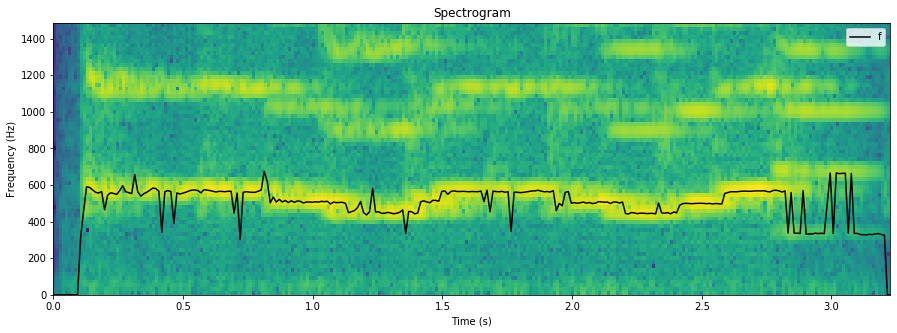

In [3]:
input_file = 'sound.wav'
window = 'hamming' 
M = 1311
N = 2048
H = 512
f0et = 5
t = -80
minf0 = 300
maxf0 = 800
fs, x = UF.wavread(input_file) 
w  = get_window(window, M)

f0 = HM.f0Detection(x, fs, w, N, H, t, minf0, maxf0, f0et) 
plot_spectrogram(input_file, window, M, N, H, f0)
y = UF.sinewaveSynth(f0, 0.8, H, fs)
ipd.display(ipd.Audio(data=y, rate=fs))

We obtain a decent time/frequency representation where we can clearly see the harmonic distribution of the sound. The f0 detection is working well overall. However, it fails to completely detect the last note and is not very consistent when notes are being held. This might be due to the vibrato effect and a possible reverb, especially for the very first one.

# F0 detection/Pitch tracking method

The pitch tracking method we chose to explore does not rely on any pattern matching algorithm as the one from the sms-tools package. Here we use instead a reference table to look up what could be the possible relationship between two frequency components of the signal. Let's summarize the different steps of the method : 

1) We apply a windowed fourier transform to the signal. 
2) For each frame, we check the magnitude spectrum and look for the highest peaks it contains.
3) We interpolate these peaks (Second order) to have a more precise estimation of their location.
4) For each pair of peaks that we found, we calculate an approximation of their GCD (greatest common divisor) : 
    
    a) For peak_1 and peak_2, we know that GCD(peak_1,peak_2)=GCD(peak_2,peak_1) and GCD(peak_1,peak_2)=GCD(peak_2-peak_1,peak_2) if peak_1<peak_2. 
    
    b) In our look-up table, we have three columns representing some harmonics relationships. The first column corresponds to the numerator, the second to the denominator, and the third to their ratio. We stored this information such as for each line, we have 2*numerator<=denominator.
    
    c) For each pair or peaks, we start by calculating their ratio. We then look in the table what is the closest ratio available. If we find one that is close enough, we state that the GCD of this pair is close to the ratio between the biggest peak of the pair divided by the corresponding denominator from the table. For example, if we have a pair of peaks (alpha, beta), with beta>alpha, whose ratio is around 0.4, we select the index (2,5) from the table. Then the estimated GCD of this pair is close to beta/5.

5) We have now a matrix gamma of size (nb_peaks,nb_peaks) containing possible f0 candidates (gamma(i,j)=GCD(peak_i,peak_j). The goal now is to choose the one that fits the best the frequency distribution of the signal. Indeed, some frequency components might share the same approximate GCD. The idea is to find the most plausible series within all the possible combinations. 

6) To help us choose between candidates, we calculate a weight matrix w of the same size as gamma such as w(i,j) = sqrt(min(peak_i,peak_j)). 

7) We then look for candidates that appear the most in gamma. We weight their number of appearances with the corresponding component of w. 

8) We calculate the overall weight of each "partition" k, that is to say : for each pitch candidate k, we sum its weighted appearances coefficients. 

9) We finally select the candidate that has the highest weighted sum.

In [4]:
# Creation of the look-up table (LUT)

LUT = np.array([
    
       [ 1.        ,  2.        ,  0.5       ],
       [ 1.        ,  3.        ,  0.33333333],
       [ 1.        ,  4.        ,  0.25      ],
       [ 1.        ,  5.        ,  0.2       ],
       [ 2.        ,  5.        ,  0.4       ],
       [ 1.        ,  6.        ,  0.16666667],
       [ 1.        ,  7.        ,  0.14285714],
       [ 2.        ,  7.        ,  0.28571429],
       [ 3.        ,  7.        ,  0.42857143],
       [ 1.        ,  8.        ,  0.125     ],
       [ 3.        ,  8.        ,  0.375     ],
       [ 1.        ,  9.        ,  0.11111111],
       [ 2.        ,  9.        ,  0.22222222],
       [ 4.        ,  9.        ,  0.44444444],
       [ 1.        , 10.        ,  0.1       ],
       [ 3.        , 10.        ,  0.3       ],
       [ 1.        , 11.        ,  0.09090909],
       [ 2.        , 11.        ,  0.18181818],
       [ 3.        , 11.        ,  0.27272727],
       [ 4.        , 11.        ,  0.36363636],
       [ 5.        , 11.        ,  0.45454545],
       [ 1.        , 12.        ,  0.08333333],
       [ 5.        , 12.        ,  0.41666667]])

       #numerator  #denominator    #ratio

In [5]:
# DFT analysis function

def dftAnal(x, w, N):
    """
    Analysis of a signal using the discrete Fourier transform
    x: input signal, w: analysis window, N: FFT size 
    returns mX, pX: magnitude and phase spectrum
    """

    if not(UF.isPower2(N)):                                 
        raise ValueError("FFT size (N) is not a power of 2")

    if (w.size > N):                                        
        raise ValueError("Window size (M) is bigger than FFT size")

    hN = (N//2)+1                                           
    hM1 = (w.size+1)//2                                     
    hM2 = w.size//2                                         
    fftbuffer = np.zeros(N)                                 
    w = w / sum(w)                                          
    xw = x*w                                                
    fftbuffer[:hM1] = xw[hM2:]                              
    fftbuffer[-hM2:] = xw[:hM2]        
    X = fft(fftbuffer)                                      
    absX = abs(X[:hN])                                      
    absX[absX<np.finfo(float).eps] = np.finfo(float).eps    
    mX = 20 * np.log10(absX)                                
    X[:hN].real[np.abs(X[:hN].real) < tol] = 0.0            
    X[:hN].imag[np.abs(X[:hN].imag) < tol] = 0.0            
    pX = np.unwrap(np.angle(X[:hN]))                        
    return mX, pX

In [6]:
# Peak detection algorithm from the sms-tools package

def peakDetection(mX, t):
    """
    Detect spectral peak locations
    mX: magnitude spectrum, t: threshold
    returns ploc: peak locations
    """
    thresh = np.where(np.greater(mX[1:-1],t), mX[1:-1], 0); 
    next_minor = np.where(mX[1:-1]>mX[2:], mX[1:-1], 0)     
    prev_minor = np.where(mX[1:-1]>mX[:-2], mX[1:-1], 0)    
    ploc = thresh * next_minor * prev_minor                 
    ploc = ploc.nonzero()[0] + 1                            
    return ploc

In [7]:
# f0 detection function

def f0Detection_(LUT,x, fs, w, N, H, t, f0t=0):
    
    if (H <= 0):                                              
        raise ValueError("Hop size (H) smaller or equal to 0")
        
    hN = N/2                                                   
    hM1 = int(math.floor((w.size+1)/2))                        
    hM2 = int(math.floor(w.size/2))                            
    x = np.append(np.zeros(hM2),x)                             
    x = np.append(x,np.zeros(hM1))                            
    pin = hM1                                                          
    pend = x.size - hM1                                        
    fftbuffer = np.zeros(N)                                   
    w = w / sum(w)                                             
    f0 = []                                                   
    f0t = 0                                                   
    f0stable = 0                                              
    
    # We keep track of the magnitude spectrum, the rectified magnitude, and its evolution (more about this below)
    #magnitudes = []
    #differences = [0]
    #differences_spectrum = [0]
    
    
    # Loading bar (cause the overall implementation is slow ...)
    pbar = tqdm(total=pend)
    
    while pin<pend:
        
        x1 = x[pin-hM1:pin+hM2]                            
        mX, pX = dftAnal(x1, w, N)      
        
        
        # We store the magnitude of the spectrum
        #magnitude = mX
        #magnitudes.append(magnitude)
        
        # We calculate the magnitude evolution from one frame to another
        #if len(magnitudes)>1:
        #    differences.append(calculate_d(magnitudes[-1],magnitudes[-2]))
        #    differences_spectrum.append(spectral_difference(magnitudes[-1],magnitudes[-2]))

        
        
        # peak detection function
        ploc = peakDetection(mX, t)                           
        
        # peak interpolation
        iploc, ipmag, ipphase = UF.peakInterp(mX, pX, ploc)      
        
        # conversion from bin to Hz
        ipfreq = fs * iploc/N                                    
        
        # conversion from dB to magnitude (needs to be positive)
        f0cm = 10**(ipmag/20)
        
        # estimating f0
        f0t = find_f0(ipfreq, f0cm, w, fs, LUT)
        
        # appending the estimated f0
        f0 = np.append(f0, f0t)                                  
        
       
        pin += H                                                 
        pbar.update(H)


    # returns the f0 track
    return f0

In [8]:
def find_denominator(LUT, x):
    """
    Finds closest harmonic ratio 
    LUT: Look Up Table, x: peaks ratio
    returns denominator, distance to perfect ratio
    """
    idx = (np.abs(LUT[:,-1] - x)).argmin()
    return LUT[idx,1], np.abs(LUT[idx,-1] - x)


def calculate_gamma(pfreq, LUT):
    """
    Calculates the gamma matrix 
    pfreq: peak locations, LUT: Look Up Table
    returns gamma
    """
    gamma = np.zeros((len(pfreq),len(pfreq)))
    
    # Finds the possible peaks combinations
    liste_permutations = list(combinations(pfreq, 2))
    
    # Iterates over each combination
    for i in liste_permutations:
        
        n_1 = np.where(pfreq==i[0])[0]
        n_2 = np.where(pfreq==i[1])[0]
        
        if n_1!=n_2:
                if 2*pfreq[n_1]<i[1]:
                    
                    # Calculates the ratio
                    quotient = i[0]/i[1]
                    
                    # Finds the closest harmonic relationship in LUT
                    denom, distance = find_denominator(LUT,quotient)
                    
                    # Measures distance between ratio and harmonic relationship
                    if distance > 0.005:
                        pass
                    else :
                        # Stores approximate GCD in gamma
                        gamma[n_1,n_2]=int(i[1]/denom)
                else:
                    quotient = (i[1]-i[0])/i[1]
                    denom, distance = find_denominator(LUT,quotient)
                    if distance > 0.005:
                        pass
                    else:
                        gamma[n_1,n_2]=int(i[1]/denom)
    return gamma


def calculate_weights(pmag):
    """
    Calculates the w matrix
    pmag: peak magnitudes
    returns w
    """
    w = np.zeros((len(pmag),len(pmag)))
    for i in range(w.shape[0]):
        for j in range(i,w.shape[1]):
            if i!=j:
                # w in symmetric
                w[i,j]=math.sqrt(min(pmag[i],pmag[j]))
                w[j,i]=math.sqrt(min(pmag[i],pmag[j]))
    return w


def binarize_k(x,k):
    """
    Binarizes a given value
    x: value, k: desired value
    returns true if x=k or k+1
    """
    return x==k or x==k+1


def thetas(c,k):
    """
    Vectorized version of 
    the previous function
    c: matrix, k: desired value
    """
    return np.vectorize(binarize_k)(c,k)


def weighted_sums(c,w):
    """
    Calculates weighted sums for
    pitch candidates
    c: GCD matrix, w: weight matrix
    returns array of weighted sums
    """
    S = []
    
    # Values of candidates
    values = np.unique(c)
    
    # For each possible candidate
    for k in tqdm(range(len(values))):
        
        # Sums up the weighted number of appearances for each pitch candidate
        S.append(np.sum(np.multiply(w,thetas(c,values[k]))))
        
    # returns array of weighted sums (candidates scores)
    return np.array(S)


def select_candidates(gamma):
    """
    Builds list of candidates
    gamma: GCD matrix
    returns list of candidates
    """
    list_candidates = []
    
    # finds all candidates in gamma
    ctr = Counter(gamma.ravel())
    
    for i in range(1,len(ctr)):
        
        # selects the most frequent candidates 
        most_common_value = ctr.most_common()[i][0]
        # adds them to the list
        list_candidates.append(most_common_value)
    
    return list_candidates


def score_candidates(liste_candidates,w,gamma):
    """
    Calculates weighted sums for
    pitch candidates
    gamma: GCD matrix, liste_candidates, 
    w : weights matrix 
    returns list of candidates
    """
    liste_scores = []
    
    for i in range(len(liste_candidates)):
        
        # sums up the weighted number of appearances for each pitch candidate
        score = np.sum(np.multiply(w,thetas(gamma,liste_candidates[i])))
        # adds score to the list
        liste_scores.append(score)
        
    return liste_scores


def select_best_candidate(liste_candidates,liste_scores):
    """
    returns the candidate with highest score
    """
    return liste_candidates[np.argmax(np.array(liste_scores))]


def find_f0(pfreq, pmag, W,F_s,LUT):
    """
    Finds f0
    pfreq: peak locations, pmag: peak magnitudes
    W: window size, F_s: sampling rate,
    LUT: Look Up Table
    returns f0
    """
    # builds gamma matrix
    gamma = calculate_gamma(pfreq,LUT)
    # builds w matrix
    w = calculate_weights(pmag)
    # builds candidates list
    liste_candidates = select_candidates(gamma)
    # calculates scores list
    liste_scores = score_candidates(liste_candidates,w,gamma)
    
    # selects best candidate
    if liste_scores == []:
        return 0
    else:
        f0 = select_best_candidate(liste_candidates,liste_scores)
    
    return f0


def calculate_d(X,Y):
    """
    Distance between two vectors
    X: vector of size n, Y: vector of size n
    returns distance
    """
    return np.sum(np.abs((X-Y)/X))


def note_change(differences):
    """
    Checks if a note change happened 
    during the last frame (or onset)
    differences: list of spectrum energies
    returns true if difference higher than 70
    """
    # If the difference is high between two consecutive
    # frames, there might have been a note change
    # empirical threshold
    return (differences[-1])>70


def calculate_octave_gap(f_1, f_2):
    """
    Check if distance between two frequencies is higher
    than an octave
    f_1: frequency (Hz), f_2: frequency (Hz)
    returns true if difference higher than f_1 or f_2
    """
    return (abs(f_1-f_2)>1*f_1) or  (abs(f_1-f_2)>1*f_2)


# Used for rectified difference (http://www.eecs.qmul.ac.uk/former/people/jbc/Documents/Bello-TSAP-2005.pdf)
def H_(x):
    if x>0:
        return (x+abs(x))/2
    else:
        return 0

    
def spectral_difference(X,Y):
    """
    Calculates the rectified difference of two vectors
    X: vector of size n, Y: vector of size n
    returns rectified difference
    """
    res = 0
    for i in range(len(X)):
        res+= H_(abs(X[i]-Y[i]))**2
    return res


def spectral_change(differences_spectrum):
    """
    Checks if a note change happened 
    during the last frame (or onset)
    differences_spectrum: list of rectified spectrum differences
    returns true if rectified difference higher than 70
    """
    # empirical threshold
    return (differences_spectrum[-1])>70_000


def post_process(f0_):
    """
    Post-processing of the f0 track
    f0_: list of f0 values, differences: list of frequency changes
    rectified: list of rectified frequency differences
    returns corrected f0 track
    """
    f0 = f0_.copy()

    # Here is a test of first detecting onsets or note changes using the spectral changes, 
    # then using these events to constrain strong changes of the pitch track
    # (More on this below)
    
    #for i in range(3,len(f0)-1):
    #   if not note_change(differences) and calculate_octave_gap(f0[i], f0[i-1]) and len(differences)>10 :
    #       f0[i]=np.mean([f0[i-2:i]])
    #for i in range(3,len(f0)-1):
    #       if not spectral_change(rectified) and calculate_octave_gap(f0[i], f0[i-1]) and len(rectified)>10 :
    #            f0[i]=np.mean([f0[i-2:i]])
    
    
    # Smoothing the f0 track :
    # Starting at index 20 to make sure we do not propagate the first errors
    for i in range(20,len(f0)-6):
        
        # if we find a sudden peak, we average it
        if abs(f0[i-1]-f0[i])>10 and abs(f0[i+1]-f0[i])>10:
            f0[i]=(f0[i-1]+f0[i+1])/2

    return f0

# F0 Detection Test

100%|█████████▉| 142336/143050 [13:56<00:00, 2532.01it/s]

Text(0.5, 0, 'Time (s)')

<Figure size 1080x360 with 0 Axes>

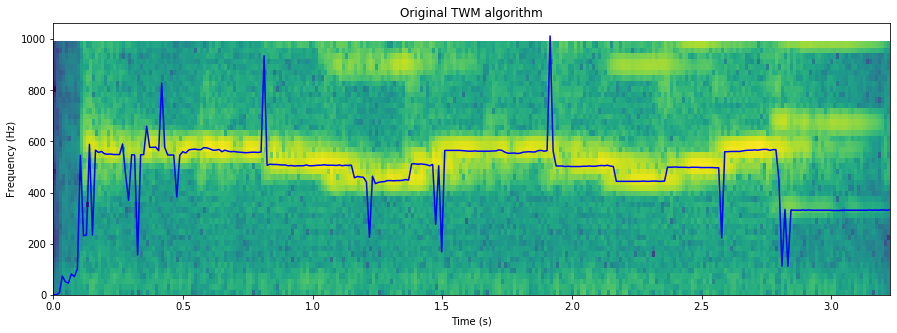

In [9]:
# test the f0Detection()

input_file = 'sound.wav'
window = 'hamming'
M = 1311
N = 2048
H = 512
t = -90


ipd.display(ipd.Audio(input_file))
fs, x = UF.wavread(input_file) 
w  = get_window(window, M)  

# We call our f0Detection function using the LUT table we created
f0_ = f0Detection_(LUT,x, fs, w, N, H, t)


## Code for plotting the f0 contour on top of the spectrogram
maxplotfreq = 1000   
plt.figure(figsize=(15, 5))

mX, pX = stft.stftAnal(x, w, N, H) 
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])
    
timeStamps = np.arange(mX.shape[1])*H/float(fs)                             
binFreqs = np.arange(mX.shape[0])*fs/float(N)


plt.figure(figsize=(15, 5))

plt.pcolormesh(timeStamps, binFreqs, mX)
plt.plot(timeStamps, f0_, color = 'b', linewidth=1.5)

plt.title('Original TWM algorithm')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')




# Visualization of the obtained pitch track 

100%|█████████▉| 142848/143050 [13:58<00:01, 170.45it/s] 


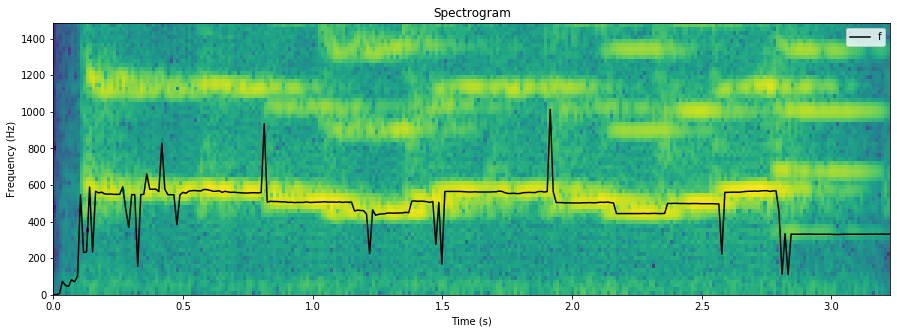

In [10]:
input_file = 'sound.wav'
window = 'hamming'
M = 1311
N = 2048
H = 512

plot_spectrogram(input_file, window, M, N, H,f0_,1500)
y = UF.sinewaveSynth(f0_, 0.8, H, fs)
ipd.display(ipd.Audio(data=y, rate=fs))

# Post-processing and visualization

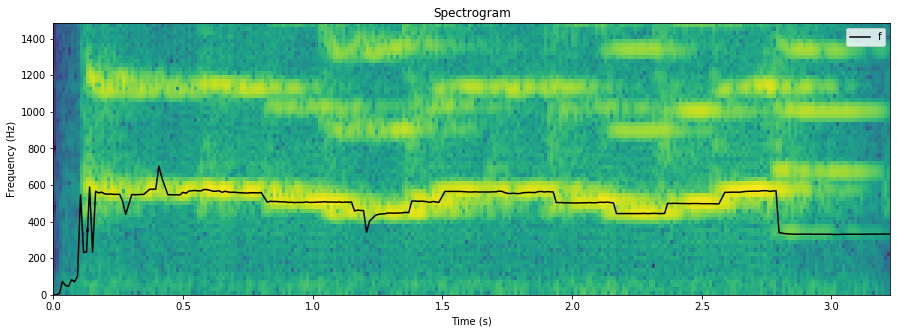

In [11]:
f0_Corrected = post_process(f0_)


input_file = 'sound.wav'
window = 'hamming'
M = 1311
N = 2048
H = 512
t = -90

plot_spectrogram(input_file, window, M, N, H,f0_Corrected,1500)
y = UF.sinewaveSynth(f0_Corrected, 0.8, H, fs)
ipd.display(ipd.Audio(data=y, rate=fs))

# Final Visual Comparison

Text(0.5, 0, 'Time (s)')

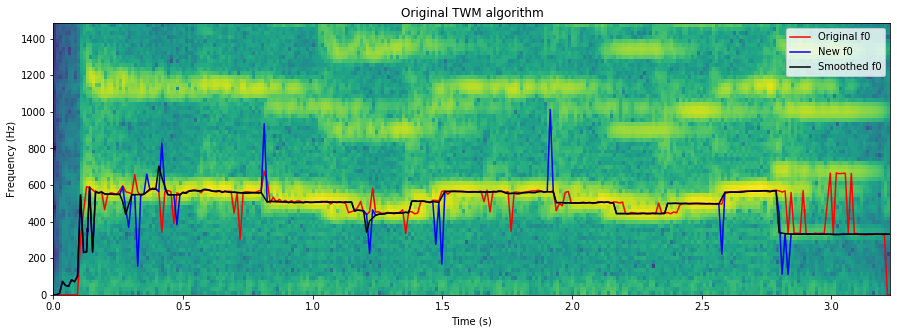

In [12]:
plt.figure(figsize=(15, 5))
maxplotfreq = 1500

mX, pX = stft.stftAnal(x, w, N, H) 
mX = np.transpose(mX[:,:int(N*(maxplotfreq/fs))+1])

timeStamps = np.arange(mX.shape[1])*H/float(fs)                             
binFreqs = np.arange(mX.shape[0])*fs/float(N)
plt.pcolormesh(timeStamps, binFreqs, mX)
plt.plot(timeStamps, f0, color = 'r', linewidth=1.5,label ='Original f0')
plt.plot(timeStamps, f0_, color = 'b', linewidth=1.5, label = 'New f0')
plt.plot(timeStamps, f0_Corrected, color = 'k', linewidth=1.5, label = 'Smoothed f0')

plt.legend()

plt.title('Original TWM algorithm')
plt.ylabel('Frequency (Hz)')
plt.xlabel('Time (s)')

# Discussion

This method seems to yield better results for bowed instruments such as the erhu. However, there are a few drawbacks/axes of improvement that need to be mentionned : 

1) Peak detection : The peak detection step could be improved. For example, it could be possible to measure the fitness of a peak based on the value of valleys that surround it. 

2) Peak selection : The peak selection step here is only approximating the actual fundamental frequency value. It would be relevant to find a way to quantize the possible candidates, carry out the selection, and then calculate a weighted average of these frequency values based on their magnitudes for example. 

3) Stability : Unlike the sms function, our method does not take into account the stability criteria. This means that, from one frame to another, there can be some big unjustified changes in the estimated f0 value.

4) The lack of stability imposes the need for a post-processing step. Here, some tests have been made to detect onsets and note changes throughout the sound. Two methods have been explored : comparing the degree of change between two consecutive frames (for the spectrum); and calculating a rectified difference between two consecutive frames. However we did not obtain good results and using the obtained onsets were making our pitch tracking results worse. However, if we manage to find these events, it could be possible to put some constrains on the f0 values in each intervals to improve stability and prevent sudden pitch changes that don't fit with the way the instrument can be played by humans. 

5) Another thing that is not perfectly rendered with the proposed method is the variation of the velocity of each note. Our method tends to just draw a pitch track that remains consistent for a given note. This is why we do not perceive as much rythm as in the original sound. The lack of rythm also comes from the fact that onsets are not recognized well, which proves the need for an onset detection algorithm to assist our method.

6) Finally, the proposed implementation is very slow. There is lots of room for improvement and optimization of the code. 

Besides these drawbacks, this method offers a few advantages compared to the sms function :

1) It does not need an initial interval for the f0. The fundamental frequency range is found automatically, which can be time saving in some applications. 

2) The resulting f0 track seems more robust than the one estimated by the Two Way Mismatch algorithm for bowed instruments such as the erhu. There seems to be a tradeoff between the accuracy of the f0 value that is estimated and the robustness to pitch variations in the sound, or in the way the instrument is played (vibrato, portamento). As this method approximates harmonic relationships by using a look up table, it does not really matter if these relationships are exactly respected among the harmonics. It does not matter either how many harmonics end up being detected, the strongest partition will always be selected. This can also solve issues that can be encountered with piano sounds, whose high harmonics are deviating from the exact ratios. 

4) The pitch values that we obtain are pretty close from the actual values. Even though it still lacks of precision, the melody can be recognized with our method.  

3) Finally, this method can also solve problems encountered when the fundamental frequency does not appear in the spectrum. Instead of adding "fake sub-harmonic values" (cf lab n°7) to match a pre-defined pattern, this method directly calculates the fundamental frequency using the look-up table. 